# Setup

In [1]:
# libraries import

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import datetime
import random

Common unit measures:
* Time: seconds
* Data: gigabytes

In [2]:
# NUMERICAL VALUES

# C: capacity of each link (in Gbit/s -> GB/s)
C = 10 / 8

# tau: time to move between two nodes (in microseconds -> seconds)
tau = 5 / 1000000

# L_f: size of input data (in TB -> GB)
L_f = 4 * 1000

# L_o: size of output data (in TB -> GB)
L_o = 4 * 1000

# E_X: expected value of X, the variable amount of time of the computational job (in hours -> seconds)
E_X = 8 * 3600

# T_0: fixed setup time (in seconds)
T_0 = 30

# xi: coefficient for average server time in job running cost calculation
xi = 0.1

# f: fracion of overhead of data given by TCP
f = 48 / 1500

# n: number of ports per switch
n = 64

# N_max: max number of parallel tasks
N_max = 10000

Work pipeline for no parallelism:
* Data arrives at server A
* A starts computation
* A ends computation and the response is available

$E[R] = T_0 + E[X] = 30 + 8 * 3.600 = 28.830$ seconds

$S = E[R] + \xi E[\Theta] = T_0 + E[X] + \xi (T_0 + E[X]) = (1 + \xi) * (T_0 + E[X]) = 1.1 * (28.830) = 31.713$ seconds


In [3]:
# E_R_local: mean response time for local computation (in seconds)
E_R_local = T_0 + E_X

# S_local: job running cost for local computation
S_local = int(E_R_local + xi * E_R_local)

Work pipeline with parallelism:
* "Build network"
* Get distances of nodes
* Data arrives at server A
* Data get sent to subservers (consider overhead | consider different "phases"?)
* Get computation time of each subserver
* Get data produced to each subserver
* Get network delay time for each subserver (consider overhead)
* Get time of slowest subserver

E[R] = E[slowest subserver work]

Each subserver work is divided into:

* Recieving data: every subserver recieves the same amount of data and the throughput depends on the RTT that depends on the distance.
* Computing data: depends on the random variable of the computation time
* Sending data: depends on the random variable of the amount of data to be sent

In [ ]:
# function to save numpy arrays into files
# since simulations may be expensive in computation time saving the files
# grant us the possibility of using the previous computations without recalculating them

def save_arrays(E_R_array, S_array):
    timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    np.save(f"E_R_array_{timestamp}.npy", E_R_array)
    np.save(f"S_array_{timestamp}.npy", S_array)

# save_arrays(E_R_array_fat, S_array_Fat)

# and with this function we can load them back into the notebook
def load_arrays(timestamp):
    E_R_array = np.load(f"E_R_array_{timestamp}.npy")
    S_array = np.load(f"S_array_{timestamp}.npy")

    return E_R_array, S_array

# Fat-Tree

In [4]:
# deterministically get array of distances of fat tree topology

def get_fat_tree_distances(N):
    # 31 servers in the same rack
    # distance 2: server -> edge switch -> sever
    same_edge_n_servers = (n // 2) - 1
    same_edge_distance = 2

    # 992 servers in the same pod
    # distance 4: server -> edge switch -> aggregation switch -> edge switch -> server
    same_pod_n_servers = (n**2) // 4 - same_edge_n_servers - 1
    same_pod_distance = 4

    # all the others
    # distance 6: server -> edge switch -> aggregation switch -> core switch -> aggregation switch -> core switch -> server
    inter_pod_n_servers = (n**3) // 4 - same_pod_n_servers - same_edge_n_servers - 1
    inter_pod_distance = 6

    if(N <= same_edge_n_servers):
        return np.full(N, same_edge_distance)
    else:
        distances_array = np.full(same_edge_n_servers, same_edge_distance)

    if(N <= same_pod_n_servers + same_edge_n_servers):
        return np.concatenate((distances_array, np.full(N - same_edge_n_servers, same_pod_distance)), axis=None)
    else:
        distances_array = np.concatenate((distances_array, np.full(same_pod_n_servers, same_pod_distance)), axis=None)

    if(N <= inter_pod_n_servers + same_pod_n_servers + same_edge_n_servers):
        return np.concatenate((distances_array, np.full(N - same_edge_n_servers - same_pod_n_servers, inter_pod_distance)), axis=None)
    else:
        raise ValueError("N is too large.")

# convert array of distances into array of rtts

def get_fat_tree_rtts(N):
    distances_array = get_fat_tree_distances(N)
    rtts_array = 2 * tau * distances_array

    return rtts_array

# convert array of rtts into array of throughputs

def get_fat_tree_throughputs(N):
    rtts_array = get_fat_tree_rtts(N)
    throughputs_array = C * (1 / rtts_array) / (1 / rtts_array).sum()

    return throughputs_array

Each subserver has a variable work time of $X_i$ distribuited as a negative exponential random variable.

$E[X_i] = E[X] / N = 1 / \lambda$

$\lambda = N / E[X]$

$X_i \sim Exp(N / E[X])$

In [7]:
n_iterations = 100000

# list of values of N to evaluate
N_list = np.concatenate((np.arange(1, 127, step = 1), np.arange(127, 1024, step = 8), np.arange(1024, 1200), np.arange(1200, 10128, step = 128)))

In [6]:
# single iteration for a single N value

def simulation_iteration_fat_tree(i, N):
    # initialize throughputs
    throughputs = get_fat_tree_throughputs(N)

    # initialize times
    times = np.full(N, 0, dtype = 'float64')

    # add recieving data time (+ overhead)
    input_amount = (L_f / N) * (1 + f)
    times += input_amount / throughputs

    # add computation time (+ setup time)
    scale = E_X / N
    computation_times = T_0 + np.random.exponential(scale, (N, ))
    times += computation_times

    # add sending data time (+ overhead)
    output_amount = (np.random.uniform(low = 0, high = 2 * L_o / N, size = (N, ))) * (1 + f)
    times += output_amount / throughputs

    # compute metrics
    E_R = np.max(times)
    S = E_R + xi * np.sum(computation_times)

    return E_R, S

# get vectorized version of function
# this way we can execute all iterations for the same N
simulation_iteration_fat_tree_v = np.vectorize(simulation_iteration_fat_tree)

# get means of all iterations for fixed N
def get_times_with_simulation_fat_tree(N):
    i = range(1, n_iterations)
    E_R_iterations, S_iterations = simulation_iteration_fat_tree_v(i, N)

    return np.mean(E_R_iterations), np.mean(S_iterations)

# get vectorized version of function
# this way we can execute all iterations for the all N values
get_times_fat_tree_v = np.vectorize(get_times_with_simulation_fat_tree)

In [162]:
################################################################
# RUN THIS CELL ONLY IF YOU WANT TO CALCULATE A NEW SIMULATION #
################################################################

# execute simulations
E_R_array_fat, S_array_fat = get_times_fat_tree_v(N_list)

# normalize values to baseline
E_R_array_fat /= E_R_local
S_array_fat /= S_local

save_arrays(E_R_array_fat, S_array_fat)

# Jellyfish

Jellyfish's original paper (https://www.usenix.org/system/files/conference/nsdi12/nsdi12-final82.pdf) states that:

"In the simplest case, which we consider by default throughout this paper, every switch has the same number of ports and servers: ∀i, k = ki and r = ri.
With N racks, the network supports N(k − r) servers. In this case, the network is a random regular graph, which we denote as RRG(N, k, r)."

"Formally, RRGs are sampled uniformly from the space of all r-regular graphs. This is a complex problem in graph theory [29]; however, a simple procedure produces “sufficiently uniform” random graphs which empirically have the desired performance properties."

In [ ]:
def get_jellyfish_max_distance(N):
    degree_nodes = 32 # since every switch has 32 ports to connect to other switches
    n_nodes = 2048 # since we want n^3 // 4 = 65536 servers and each switch has 32 server -> 65536 / 32 = 2048

    needed_switches = int(np.ceil((N + 1) / 32))

    # Create Jellyfish graph
    switches_graph = nx.random_regular_graph(d = degree_nodes, n = n_nodes)

    # Select a random node from the graph
    random_node = random.choice(list(switches_graph.nodes()))

    # Calculate distances from the random node to all other nodes
    distances = nx.shortest_path_length(switches_graph, source=random_node)

    # Sort the distances and get the closest
    sorted_distances = sorted(distances.values())

    switches_distances = np.array(sorted_distances[:needed_switches])

    # convert switch distances into server distances
    # add 2 to count for link between source server and switch
    # and between destination and switch    
    # for every switch add 32 servers except for the first one
    # which will only have 31 and the last one that will have as
    # enough to complete the request

    server_distances = np.repeat(switches_distances + 2, 32)[1 : N + 1]

    return np.max(server_distances)

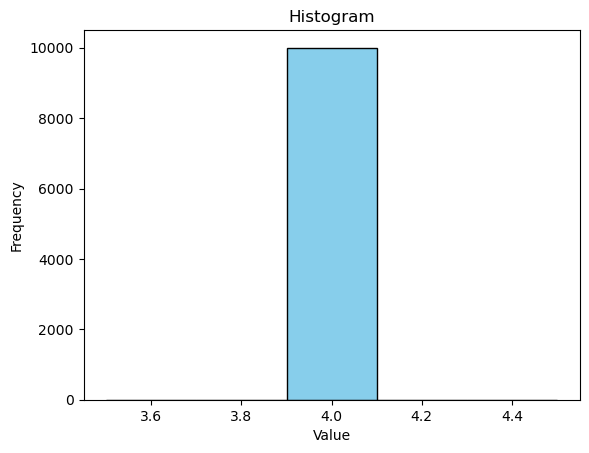

In [ ]:
n_iterations = 10000
data = []

for _ in range(1, n_iterations):
    data.append(get_jellyfish_max_distance(N = 10000))

plt.hist(data, bins=5, color='skyblue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

plt.show()

In [ ]:
n_iterations = 100000

# list of values of N to evaluate
N_list = np.concatenate((np.arange(1, 127, step = 1), np.arange(127, 1024, step = 8), np.arange(1024, 1200), np.arange(1200, 10128, step = 128)))

In [131]:
def get_jellyfish_distances_deterministic(N):
    # the first servers we get are those in the same rack as the main server
    # there are 31 servers beside the main one
    # distance is 2 since we go from server to switch and back to server
    same_rack_n_servers = (n // 2) - 1
    same_rack_distance = 2

    # main server's switch has 32 links to other swithces
    # since there are no loops all those new switches are 'unexplored'
    # distance for those servers is 4
    near_rack_n_servers = (n // 2)**2
    near_rack_distance = 3

    far_rack_distance = 4

    if(N <= same_rack_n_servers):
        return np.full(N, same_rack_distance)
    else:
        distances_array = np.full(same_rack_n_servers, same_rack_distance)

    if(N <= near_rack_n_servers + same_rack_n_servers):
        return np.concatenate((distances_array, np.full(N - same_rack_n_servers, near_rack_distance)), axis=None)
    else:
        distances_array = np.concatenate((distances_array, np.full(near_rack_n_servers, near_rack_distance)), axis=None)

    if(N <= n**3 // 4):
        return np.concatenate((distances_array, np.full(N - same_rack_n_servers - near_rack_n_servers, far_rack_distance)), axis=None)
    else:
        raise ValueError("N is too large.")

def get_jellyfish_rtts(N):
    distances_array = get_jellyfish_distances_deterministic(N)
    rtts_array = 2 * tau * distances_array

    return rtts_array

def get_jellyfish_throughputs(N):
    rtts_array = get_jellyfish_rtts(N)
    throughputs_array = C * (1 / rtts_array) / (1 / rtts_array).sum()

    return throughputs_array

In [129]:
def simulation_iteration_jellyfish(i, N):
    # initialize throughputs
    throughputs = get_jellyfish_throughputs(N)

    # initialize times
    times = np.full(N, 0, dtype = 'float64')

    # add recieving data time (+ overhead)
    input_amount = (L_f / N) * (1 + f)
    times += input_amount / throughputs

    # add computation time (+ setup time)
    scale = E_X / N
    computation_times = T_0 + np.random.exponential(scale, (N, ))
    times += computation_times

    # add sending data time (+ overhead)
    output_amount = (np.random.uniform(low = 0, high = 2 * L_o / N, size = (N, ))) * (1 + f)
    times += output_amount / throughputs

    # compute metrics
    E_R = np.max(times)
    S = E_R + xi * np.sum(computation_times)

    return E_R, S

simulation_iteration_jellyfish_v = np.vectorize(simulation_iteration_jellyfish)

def get_times_with_simulation_jellyfish(N):
    i = range(1, n_iterations)
    E_R_iterations, S_iterations = simulation_iteration_jellyfish_v(i, N)

    return np.mean(E_R_iterations), np.mean(S_iterations)

get_times_jellyfish_v = np.vectorize(get_times_with_simulation_jellyfish)

In [ ]:
E_R_array_jelly, S_array_jelly = get_times_jellyfish_v(N_list)

# normalize

E_R_array_jelly /= E_R_local
S_array_jelly /= S_local

In [ ]:
save_arrays(E_R_array_jelly, S_array_jelly)

# Plots

In [61]:
print(N_list[np.argmin(E_R_array_fat)])
print(N_list[np.argmin(E_R_array_jelly)])

1023
1055


In [109]:
print(np.min(E_R_array_jelly))

0.3516325057556366


In [113]:
print(N_list[np.argmin(S_array_fat)])
print(N_list[np.argmin(S_array_jelly)])

31
263


In [115]:
print(np.min(S_array_fat))
print(np.min(S_array_jelly))

0.46754222420129726
0.4538724544617108


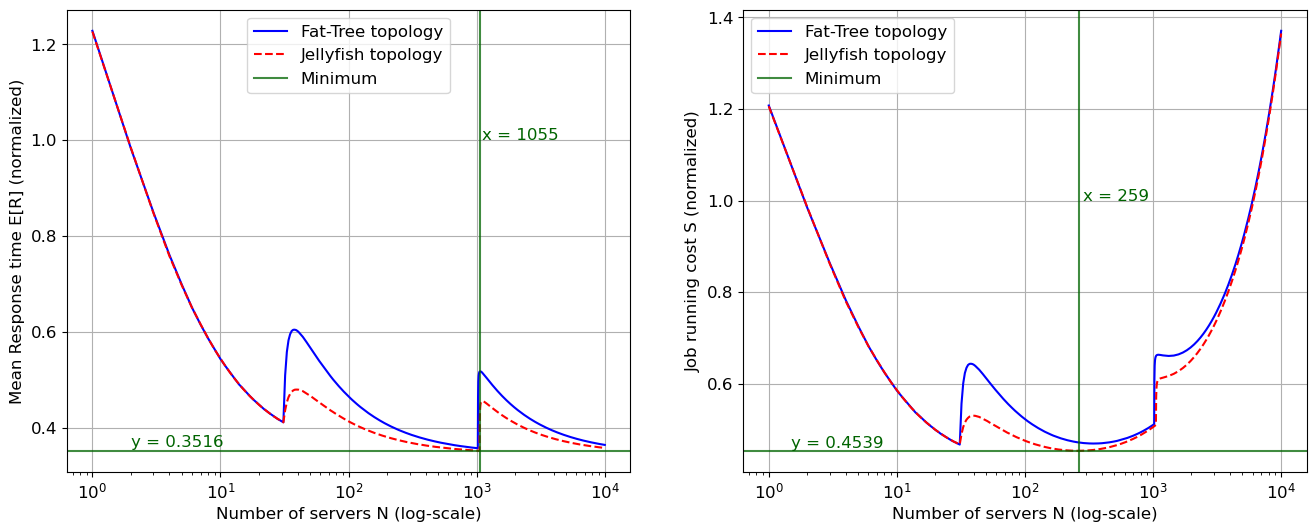

In [146]:
E_R_array_fat, S_array_fat = load_arrays("100kfat")
E_R_array_jelly, S_array_jelly = load_arrays("100kjelly")

plt.rcParams.update({'font.size': 12})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(N_list, E_R_array_fat, color='blue', label = 'Fat-Tree topology')
ax1.plot(N_list, E_R_array_jelly, color='red', label = 'Jellyfish topology', linestyle='--')

ax1.axvline(x = N_list[np.argmin(E_R_array_jelly)], color='darkgreen', alpha = 0.75, label = 'Minimum')
ax1.axhline(y = np.min(E_R_array_jelly), color='darkgreen', alpha = 0.75)
ax1.text(1100, 1, 'x = 1055', color = 'darkgreen')
ax1.text(2, 0.36, 'y = 0.3516', color = 'darkgreen')

ax1.set_xlabel('Number of servers N (log-scale)')
ax1.set_ylabel('Mean Response time E[R] (normalized)')
ax1.grid(True)
ax1.set_xscale('log')
ax1.legend()


ax2.plot(N_list, S_array_fat, color='blue', label = 'Fat-Tree topology')
ax2.plot(N_list, S_array_jelly, color='red', label = 'Jellyfish topology', linestyle='--')

ax2.axvline(x = N_list[np.argmin(S_array_jelly)], color='darkgreen', alpha = 0.75, label = 'Minimum')
ax2.axhline(y = np.min(S_array_jelly), color='darkgreen', alpha = 0.75)
ax2.text(285, 1, 'x = 259', color = 'darkgreen')
ax2.text(1.5, 0.46, 'y = 0.4539', color = 'darkgreen')

ax2.set_xlabel('Number of servers N (log-scale)')
ax2.set_ylabel('Job running cost S (normalized)')
ax2.grid(True)
ax2.set_xscale('log')
ax2.legend()

plt.show()

In [143]:
N_list_new = range(263-9, 263+9)
n_iterations = 100000

E_R_array_jelly_new, S_array_jelly_new = get_times_jellyfish_v(N_list_new)

# normalize

E_R_array_jelly_new /= E_R_local
S_array_jelly_new /= S_local

In [144]:
print(N_list_new[np.argmin(S_array_jelly_new)])
print(np.min(S_array_jelly_new))

259
0.45386068891358167
